In [3]:
### Notebook depicting some steps of the analysis workflow for the ScaleFEx dataset

import pandas as pd
import numpy as np
import sklearn
import sklearn.linear_model
import sklearn.ensemble
import os
import seaborn as sns
import matplotlib.pyplot as plt
### Moving working directory to project root...


In [5]:
## Load data
Vecmean=pd.read_csv('data/ScaleFEx_corrected_averaged_features.csv',index_col=0)

In [6]:
## Convert to numeric
cols=Vecmean.columns[13:-4]
Vecmean[cols]=Vecmean[cols].astype(float)

In [7]:
## Define metadata
cols_meta=['plate','well','Age','Sex','PD_status','well_row','well_col','drug_id','concentration',
 'Name','Pathway','drug','donor_id']

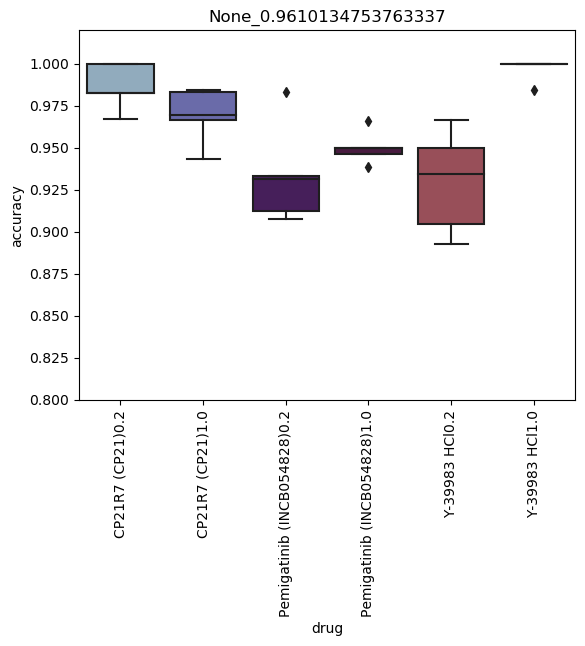

In [8]:
## Linear regression features sort

from sklearn.datasets import load_digits
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
norms=['plate','donor_id','ColPos','RowPos']
norms=[]
name='plateDonorColRow'
name="None"
columns=cols
Vecmean=Vecmean.fillna(0)
model = LinearRegression()


model.fit(Vecmean[columns], Vecmean.drug_id.values)
features_LR={}   
Results=pd.DataFrame(columns=['plate','drug','accuracy'])
for i in np.unique(Vecmean.drug):
    if i != 'StockDMSO':
   
        features_LR[i]=pd.DataFrame(columns=columns)
        temp=Vecmean.loc[Vecmean.drug==i]
        temp=pd.concat([temp,Vecmean.loc[Vecmean.drug=='StockDMSO']])
        temp['drug_id']=0
        temp.loc[temp.drug!='StockDMSO','drug_id']=1
        temp=temp.drop(temp.loc[temp.drug_id==0].sample(len(temp.loc[temp.drug_id==1])).index)
        for plate in np.unique(temp.plate):
            model.fit(temp.loc[temp.plate!=plate][columns], temp.loc[temp.plate!=plate].drug_id.values)
            features_LR[i].loc[plate]=model.coef_
            temp2=[plate,i,sklearn.metrics.accuracy_score(temp.loc[temp.plate==plate]['drug_id'],np.round(model.predict(temp.loc[temp.plate==plate][columns])))]
            Results=pd.concat([Results,pd.DataFrame(np.asarray(temp2).reshape(1,3),columns=['plate','drug','accuracy'])],axis=0)
Results['accuracy']=Results['accuracy'].astype(float)
sns.boxplot(data=Results,y='accuracy',x='drug',palette='twilight')
_=plt.xticks(rotation=90)

plt.title(name+'_'+str(np.mean(Results.accuracy)))
plt.ylim([0.8,1.02])
plt.show()



In [7]:
### Variance thresholding: removes the columns with low variance
from sklearn.feature_selection import VarianceThreshold

columns=cols
X = Vecmean[columns]
print(X.shape)
sel = VarianceThreshold()
X=sel.fit_transform(X)
print(X.shape)
cols_red=sel.get_feature_names_out()

(1195, 320)
(1195, 320)


In [8]:
## Recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
preds_LR_fin={}

model={}
features={}
preds_LR_fin={}
cols_red=cols[:-1]
auc={}
best_nfeats=[65, 43, 195, 160, 104, 14]
for n,i in enumerate(np.unique(Vecmean.loc[Vecmean.drug!='StockDMSO'].drug)):
    

    
    if i != 'StockDMSO':
        model[i]={}
        preds_LR_fin[i]=pd.DataFrame()
       
        n_feat=np.asarray(best_nfeats)[n]
     
        temp=Vecmean.loc[Vecmean.drug==i]
        temp=pd.concat([temp,Vecmean.loc[Vecmean.drug=='StockDMSO']])
        temp['drug_id']=0
        temp.loc[temp.drug!='StockDMSO','drug_id']=1
    
        accuracy=[]
        auc[i]=[]
        lenF=[]
        features[i]=pd.DataFrame()
        for plate in np.unique(Vecmean.plate):
            clf = LogisticRegression(max_iter=10000,random_state=0)
            LR = LogisticRegression(max_iter=10000,random_state=0)
            
            drug=temp.loc[(temp.plate!=plate)&(temp.drug==i)]
            X_train=pd.concat([drug,temp.loc[(temp.plate!=plate)&(temp.drug=='StockDMSO')].sample(len(drug))])
            X_train=X_train
            y_train=X_train['drug_id']
            X_train=X_train[cols_red]

            X_test=temp.loc[temp.plate==plate][cols_red]
            y_test=temp.loc[temp.plate==plate]['drug_id']
            rfe = RFE(estimator=clf, n_features_to_select=n_feat)
          
            rfe.fit(X_train, y_train)
            mask = rfe.support_
            important_non_correlated_features=X_train.columns[mask]

            lenF.append(len(important_non_correlated_features))
            X_test = X_test[important_non_correlated_features]
            LR.fit(X_train[important_non_correlated_features],y_train)
     
            model[i][plate]=LR
         
            features[i][plate]=important_non_correlated_features
            auc[i].append(sklearn.metrics.roc_auc_score(y_test,LR.predict(X_test[important_non_correlated_features])))
            accuracy.append(sklearn.metrics.accuracy_score(y_test,LR.predict(X_test[important_non_correlated_features])))

        t2=pd.DataFrame()
        t2.loc[n,'drug']=i
        t2.loc[n,'feat_parameter']=n_feat
        t2.loc[n,'final_parameter_n']=np.mean(lenF)
        t2.loc[n,'Accuracy']=np.mean(accuracy)
        t2.loc[n,'AUC']=np.mean(auc[i])
        preds_LR_fin[i]=pd.concat([preds_LR_fin[i],t2])
        print(preds_LR_fin[i])

               drug  feat_parameter  final_parameter_n  Accuracy       AUC
0  CP21R7 (CP21)0.2            65.0               65.0  0.997778  0.998333
               drug  feat_parameter  final_parameter_n  Accuracy  AUC
1  CP21R7 (CP21)1.0            43.0               43.0       1.0  1.0
                          drug  feat_parameter  final_parameter_n  Accuracy  \
2  Pemigatinib (INCB054828)0.2           195.0              195.0  0.984444   

    AUC  
2  0.98  
                          drug  feat_parameter  final_parameter_n  Accuracy  \
3  Pemigatinib (INCB054828)1.0           160.0              160.0  0.988889   

        AUC  
3  0.986667  
             drug  feat_parameter  final_parameter_n  Accuracy       AUC
4  Y-39983 HCl0.2           104.0              104.0  0.995531  0.996667
             drug  feat_parameter  final_parameter_n  Accuracy  AUC
5  Y-39983 HCl1.0            14.0               14.0       1.0  1.0


/tmp/ipykernel_199702/2460405767.py:10: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=results_for_plot,y='auc',x='drug',s=9,jitter=0.3,linewidth=0.5,palette=pal,order=['Y-39983 HCl0.2','Y-39983 HCl1.0','Pemigatinib (INCB054828)0.2','Pemigatinib (INCB054828)1.0','CP21R7 (CP21)0.2','CP21R7 (CP21)1.0'])
/home/biancamigliori/miniconda3/envs/ScaleFEx_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/biancamigliori/miniconda3/envs/ScaleFEx_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/biancamigliori/miniconda3/envs/ScaleFEx_e

(0.85, 1.01)

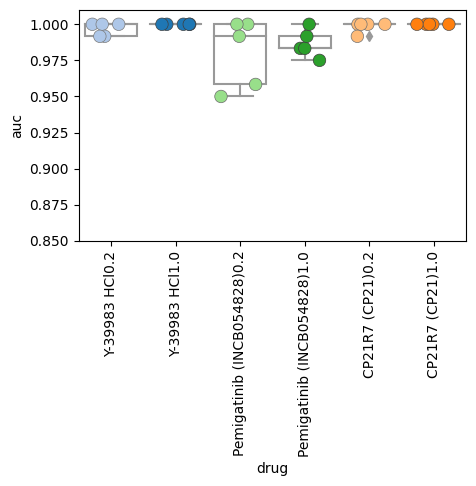

In [9]:
## Plot the results
results_for_plot=pd.DataFrame()
pal=['#aec7e8','#1f77b4','#98df8a','#2ca02c', '#ffbb78' ,'#ff7f0e']
for i in auc.keys():
    temp=pd.DataFrame()
    temp['auc']=auc[i]
    temp['drug']=i
    results_for_plot=pd.concat([results_for_plot,temp],axis=0)
plt.subplots(figsize=(5,3))
sns.boxplot(data=results_for_plot,y='auc',x='drug',color='white',order=['Y-39983 HCl0.2','Y-39983 HCl1.0','Pemigatinib (INCB054828)0.2','Pemigatinib (INCB054828)1.0','CP21R7 (CP21)0.2','CP21R7 (CP21)1.0'])
sns.stripplot(data=results_for_plot,y='auc',x='drug',s=9,jitter=0.3,linewidth=0.5,palette=pal,order=['Y-39983 HCl0.2','Y-39983 HCl1.0','Pemigatinib (INCB054828)0.2','Pemigatinib (INCB054828)1.0','CP21R7 (CP21)0.2','CP21R7 (CP21)1.0'])
_=plt.xticks(rotation=90)
plt.ylim([0.85,1.01])


In [10]:
### Add channel features    
def add_channel_features(feat):
    ''' 
    Returns the channels of the features taken as the input
    '''
    ch=[]
    for n in range(1,6):
        if 'ch'+str(n) in feat:
            ch.append(['ER','Mito','AGP','DNA','RNA'][n-1])
    if 'Mito' in feat:
        ch.append('Mito')
    if 'RNA' in feat:
        ch.append('RNA')
    if len(ch)==0:
        ch.append('None')
    return ch


/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.36119063312768074' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  a.loc[a.features==feat,'coefficient_Plate'+str(f+1)]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.38757512025127416' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  a.loc[a.features==feat,'coefficient_Plate'+str(f+1)]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.337145515

Texture_dist_3angle1.05ch4
FormFactor_shapech4
Eccentricity_shapech4
MassDisplacement_intensitych4
Granularity_ch4_11_Conc1
Concent_Radial_intensity_2_5_ch4
Concent_Radial_intensity_2_7_ch4
Zernike_ch4_7
Zernike_ch4_4
Zernike_ch4_8
Zernike_ch4_9
Zernike_ch4_14
Zernike_ch4_16
Zernike_ch4_18
Zernike_ch4_20
Zernike_ch4_21
Zernike_ch4_22
Zernike_ch4_23
MinRadius_shapech1
MaxRadius_shapech1
Eccentricity_shapech1
MassDisplacement_intensitych1
Concent_Radial_intensity_1_7_ch1
Concent_Radial_intensity_4_7_ch1
Zernike_ch1_1
Zernike_ch1_2
Zernike_ch1_3
Zernike_ch1_8
Zernike_ch1_10
Zernike_ch1_11
Zernike_ch1_15
Zernike_ch1_19
Zernike_ch1_21
Zernike_ch1_24
MaxRadius_shapech5
Solidity_shapech5
Eccentricity_shapech5
TextContrast_dist_2angle0.0ch5
Variance_Texturech5
MassDisplacement_intensitych5
Concent_Radial_intensity_1_4_ch5
Concent_Radial_intensity_1_5_ch5
Concent_Radial_intensity_1_6_ch5
Zernike_ch5_1
Zernike_ch5_5
Zernike_ch5_8
Zernike_ch5_10
Zernike_ch5_14
Zernike_ch5_15
Zernike_ch5_16
Perime

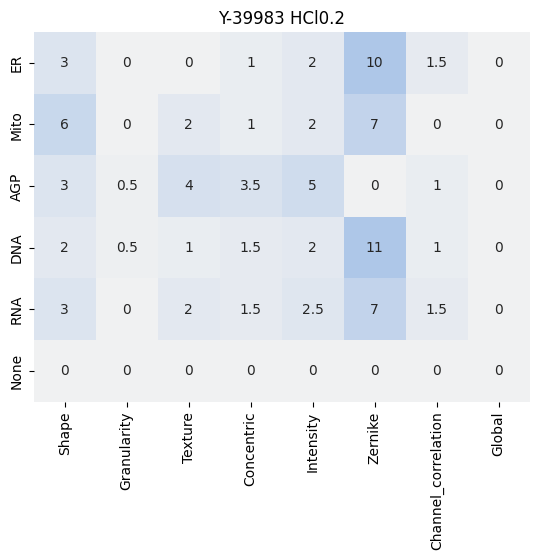

/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.2411646254357105' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  a.loc[a.features==feat,'coefficient_Plate'+str(f+1)]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.2116387165374891' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  a.loc[a.features==feat,'coefficient_Plate'+str(f+1)]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.22696653

MaxRadius_shapech1
Concent_Radial_intensity_4_7_ch1
Zernike_ch1_1
Zernike_ch1_2
Zernike_ch1_10
MaxRadius_shapech5
Zernike_ch5_1
Zernike_ch5_2
Zernike_ch5_10
Solidity_shapech3
Concent_Radial_intensity_1_5_ch3
Concent_Radial_intensity_1_6_ch3
Zernike_ch2_10
Y-39983 HCl1.0 True


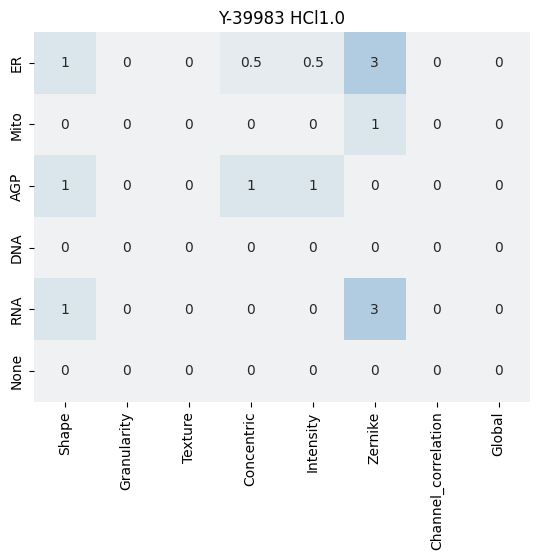

/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7665863622321645' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  a.loc[a.features==feat,'coefficient_Plate'+str(f+1)]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6838198074231957' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  a.loc[a.features==feat,'coefficient_Plate'+str(f+1)]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.78051571898

Texture_dist_3angle1.05ch4
Solidity_shapech4
Eccentricity_shapech4
TextCorrelation_dist_4angle1.05ch4
Granularity_ch4_11_Conc1
Concent_Radial_intensity_2_3_ch4
Zernike_ch4_7
Zernike_ch4_20
Zernike_ch4_21
Zernike_ch4_22
MinRadius_shapech1
MaxRadius_shapech1
Texture_dist_3angle1.05ch1
MassDisplacement_intensitych1
Concent_Radial_intensity_4_7_ch1
Zernike_ch1_1
Zernike_ch1_2
Zernike_ch1_10
MaxRadius_shapech5
MassDisplacement_intensitych5
Zernike_ch5_1
Zernike_ch5_2
Zernike_ch5_10
Zernike_ch5_16
Zernike_ch5_17
Solidity_shapech3
Std_intensityEdge_ch3
Concent_Radial_intensity_1_3_ch3
Concent_Radial_intensity_1_4_ch3
Concent_Radial_intensity_1_5_ch3
Concent_Radial_intensity_1_6_ch3
Concent_Radial_intensity_1_7_ch3
MinRadius_shapech2
Extent_shapech2
Solidity_shapech2
TextCorrelation_dist_2angle0.0ch2
Integrated_intensityEdge_ch2
Concent_Radial_intensity_2_6_ch2
Concent_Radial_intensity_5_7_ch2
Zernike_ch2_1
Zernike_ch2_4
Zernike_ch2_10
Zernike_ch2_17
Zernike_ch2_18
MitoVolumeSkel
MitoStdEndPoi

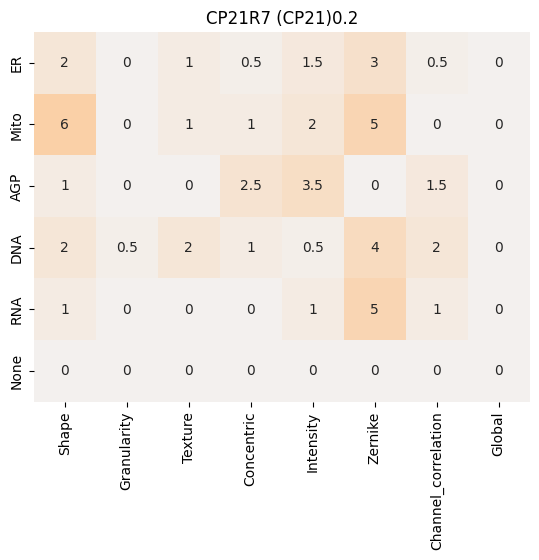

/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.597595084529016' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  a.loc[a.features==feat,'coefficient_Plate'+str(f+1)]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.5725935469096471' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  a.loc[a.features==feat,'coefficient_Plate'+str(f+1)]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.539824535

Solidity_shapech4
Zernike_ch4_10
Zernike_ch4_21
MinRadius_shapech1
MaxRadius_shapech1
Texture_dist_3angle1.05ch1
MassDisplacement_intensitych1
Concent_Radial_intensity_1_7_ch1
Concent_Radial_intensity_4_7_ch1
Zernike_ch1_1
Zernike_ch1_2
Zernike_ch1_10
Zernike_ch1_17
Zernike_ch1_20
Zernike_ch1_21
MaxRadius_shapech5
Concent_Radial_intensity_3_7_ch5
Zernike_ch5_1
Zernike_ch5_2
Zernike_ch5_10
Zernike_ch5_16
FormFactor_shapech3
Solidity_shapech3
Concent_Radial_intensity_1_3_ch3
Concent_Radial_intensity_1_4_ch3
Concent_Radial_intensity_1_5_ch3
Concent_Radial_intensity_1_6_ch3
Extent_shapech2
Concent_Radial_intensity_5_7_ch2
Zernike_ch2_1
Zernike_ch2_10
Zernike_ch2_18
MitoVolumeSkel
Correlation_Slope_ch4_ch3
Correlation_Overlap_ch1_ch5
Correlation_Overlap_ch1_ch3
Correlation_Overlap_ch5_ch3
CP21R7 (CP21)1.0 True


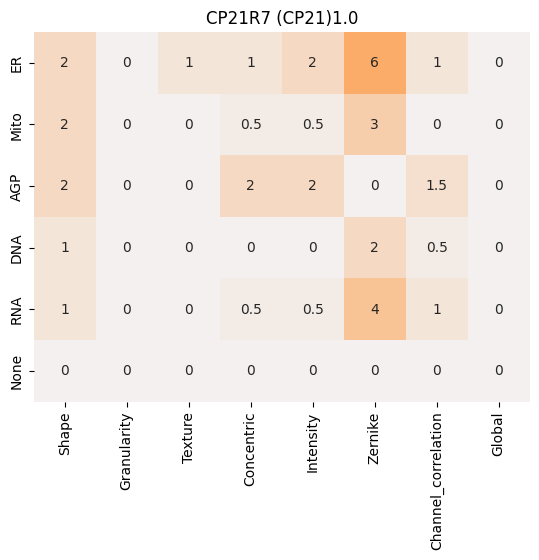

/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.18912137131026188' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  a.loc[a.features==feat,'coefficient_Plate'+str(f+1)]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2468851442514042' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  a.loc[a.features==feat,'coefficient_Plate'+str(f+1)]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4764489775

FormFactor_shapech4
Eccentricity_shapech4
Granularity_ch4_7_Conc0
MassDisplacement_intensitych4
Concent_mean_intensity_4ch4
Zernike_ch4_7
Zernike_ch4_4
Zernike_ch4_10
Zernike_ch4_8
Zernike_ch4_9
Zernike_ch4_11
Zernike_ch4_14
Zernike_ch4_15
Zernike_ch4_16
Zernike_ch4_17
Zernike_ch4_18
Zernike_ch4_21
Zernike_ch4_22
SNR_intensitych1
MinRadius_shapech1
MaxRadius_shapech1
Texture_dist_3angle1.05ch1
Perimeter_shapech1
FormFactor_shapech1
Eccentricity_shapech1
TextContrast_dist_3angle1.05ch1
TextCorrelation_dist_4angle2.09ch1
Max_intensity_ch1
Integrated_intensityEdge_ch1
Std_intensityEdge_ch1
MassDisplacement_intensitych1
Granularity_ch1_15_Conc1
Concent_Radial_intensity_1_7_ch1
Concent_Radial_intensity_4_6_ch1
Concent_Radial_intensity_4_7_ch1
Zernike_ch1_1
Zernike_ch1_2
Zernike_ch1_3
Zernike_ch1_8
Zernike_ch1_10
Zernike_ch1_11
Zernike_ch1_12
Zernike_ch1_14
Zernike_ch1_15
Zernike_ch1_17
Zernike_ch1_18
Zernike_ch1_19
Zernike_ch1_20
Zernike_ch1_23
Zernike_ch1_24
SNR_intensitych5
MaxRadius_shap

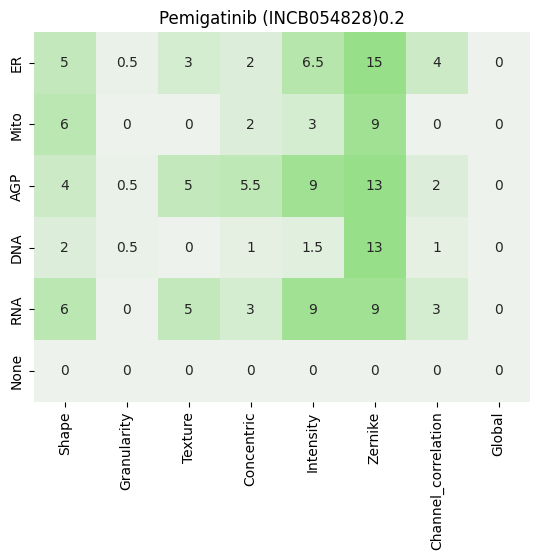

/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3492192943818737' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  a.loc[a.features==feat,'coefficient_Plate'+str(f+1)]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.47186384051109076' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  a.loc[a.features==feat,'coefficient_Plate'+str(f+1)]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4229195191

Texture_dist_3angle1.05ch4
FormFactor_shapech4
Solidity_shapech4
Eccentricity_shapech4
TextCorrelation_dist_4angle1.05ch4
MassDisplacement_intensitych4
Concent_Radial_intensity_2_3_ch4
Zernike_ch4_4
Zernike_ch4_10
Zernike_ch4_8
Zernike_ch4_9
Zernike_ch4_11
Zernike_ch4_15
Zernike_ch4_16
Zernike_ch4_17
Zernike_ch4_18
Zernike_ch4_23
SNR_intensitych1
MinRadius_shapech1
MaxRadius_shapech1
FormFactor_shapech1
Eccentricity_shapech1
Max_intensity_ch1
Integrated_intensityEdge_ch1
Std_intensityEdge_ch1
Concent_Radial_intensity_2_3_ch1
Concent_Radial_intensity_4_7_ch1
Zernike_ch1_1
Zernike_ch1_3
Zernike_ch1_7
Zernike_ch1_8
Zernike_ch1_9
Zernike_ch1_11
Zernike_ch1_14
Zernike_ch1_15
Zernike_ch1_19
Zernike_ch1_23
Zernike_ch1_24
SNR_intensitych5
MaxRadius_shapech5
Perimeter_shapech5
FormFactor_shapech5
Solidity_shapech5
Eccentricity_shapech5
Max_intensity_ch5
MassDisplacement_intensitych5
Concent_Radial_intensity_1_2_ch5
Concent_Radial_intensity_1_6_ch5
Concent_Radial_intensity_3_7_ch5
Zernike_ch5_1


/tmp/ipykernel_199702/3132581668.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3909418603649025' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  a.loc[a.features==feat,'coefficient_Plate'+str(f+1)]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
/tmp/ipykernel_199702/3132581668.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  feat_bar.loc[c,bb]+=1/(len(b)+len(add_channel_features(ff))-1)
/tmp/ipykernel_199702/3132581668.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fe

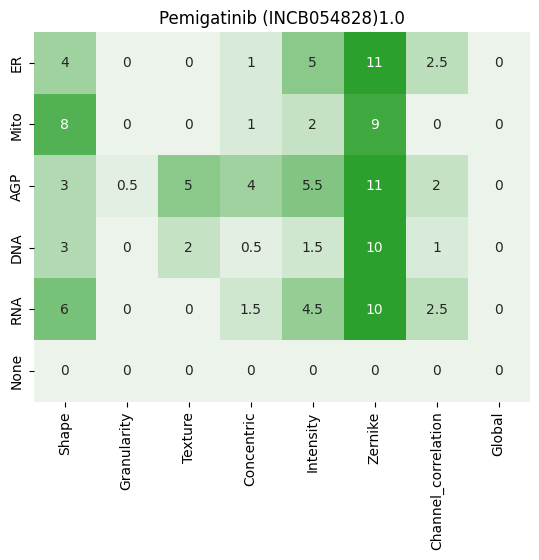

In [11]:
### remove correlated features after putting the 5 CVs together
pale=sns.color_palette("twilight",7).as_hex()
tot_features_summary={}
pale=['#aec7e8','#1f77b4', '#ffbb78', '#ff7f0e',  '#98df8a', '#2ca02c']
for n,i in enumerate([ 'Y-39983 HCl0.2', 'Y-39983 HCl1.0','CP21R7 (CP21)0.2', 'CP21R7 (CP21)1.0',
       'Pemigatinib (INCB054828)0.2', 'Pemigatinib (INCB054828)1.0']):
    if i!='StockDMSO':
        a=pd.DataFrame()
        f=0
     
        for f,key in enumerate(model[i].keys()):
            if f==0:

                a['features']=model[i][key].feature_names_in_
                a['coefficient_Plate1']=model[i][key].coef_[0]


            else:
                a['coefficient_Plate'+str(f+1)]=0
                for feat in model[i][key].feature_names_in_:


                    if feat in list(a.features.values):

                        a.loc[a.features==feat,'coefficient_Plate'+str(f+1)]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
                    else:
          
                        temp=np.zeros((1,f+2)).astype(object)
                        temp[0][0]=feat
                        temp[0][f+1]=model[i][key].coef_[0][np.where(feat==model[i][key].feature_names_in_)[0]][0]
                        a=pd.concat([a,pd.DataFrame(temp,columns=a.columns,index=[a.index[-1]+1])])

        a['sum_of_coefficients']=abs(a.iloc[:,1:]).sum(axis=1)
        a['total_counts']=(a.iloc[:,1:-1]!=0.0).sum(axis=1)   
        
        a=a[a.features.isin(X_train.columns)]
        
        tot_features_summary[i]=a
        feat_bar=pd.DataFrame(0,columns=['Shape','Granularity','Texture','Concentric','Intensity','Zernike','Channel_correlation','Global'],index=['ER','Mito','AGP','DNA','RNA','None'])
        
        for ff in a.loc[a.total_counts==5].features:
            b=[]
            print(ff)
            if ("intensity" in ff) or ("Int" in ff):
                 b.append('Intensity')

            if ("Solidity" in ff) or ('Perimeter' in ff) or ('hape' in ff) or ("Eccentricity" in ff) or ('RNA' in ff) or ('Mito' in ff):
                 b.append('Shape')

            if ('Granularity' in ff):
                 b.append('Granularity')

            if ("ext" in ff) :
                 b.append('Texture')
            if ("ernike" in ff) :
                 b.append('Zernike')

            if ('Conc' in ff) :
                 b.append('Concentric')
            if ('Mander' in ff) or ('Slope' in ff) or ('Overlap' in ff) or ('RWC' in ff) or ('Correlation_c' in ff):
                b.append('Channel_correlation')
            if len(b)==0:
       
                b.append('Global')

            for c in add_channel_features(ff):
                for bb in b:
                    feat_bar.loc[c,bb]+=1/(len(b)+len(add_channel_features(ff))-1)

        print(i,len(a.loc[a.total_counts==5].features)==feat_bar.sum().sum())
        cmap=sns.light_palette(pale[n], as_cmap=True)


        sns.heatmap(feat_bar,annot=True,vmax=10,cmap=cmap,cbar=False)
        #
        plt.title(i)
        plt.show()


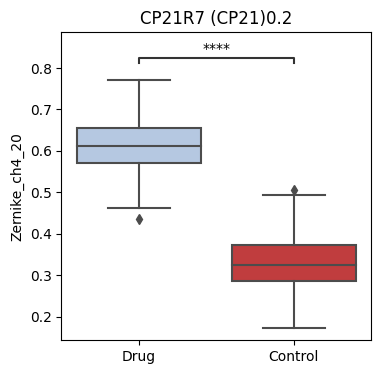

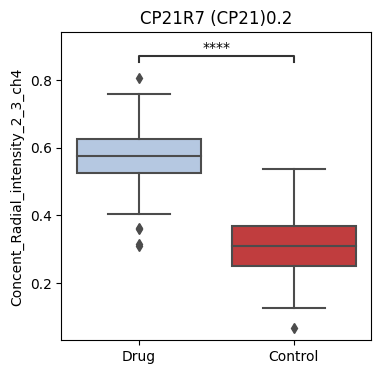

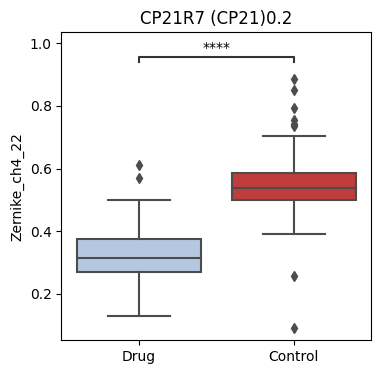

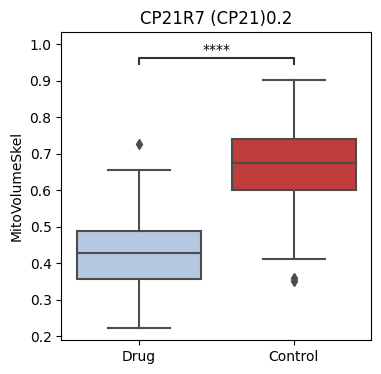

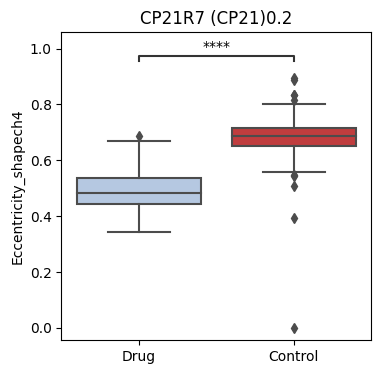

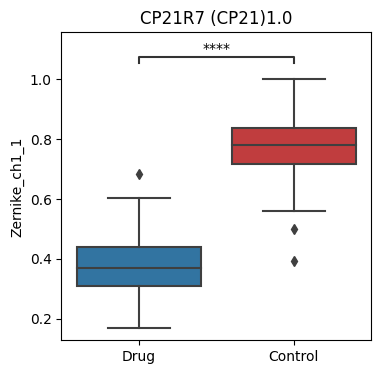

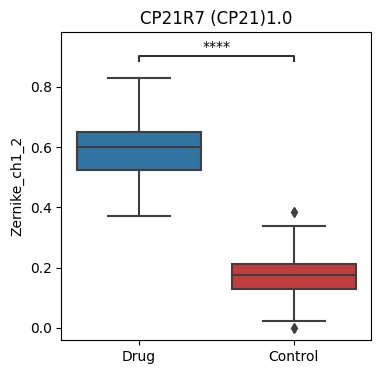

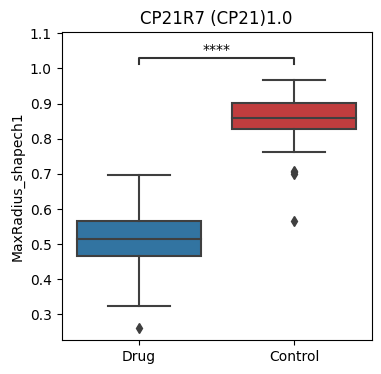

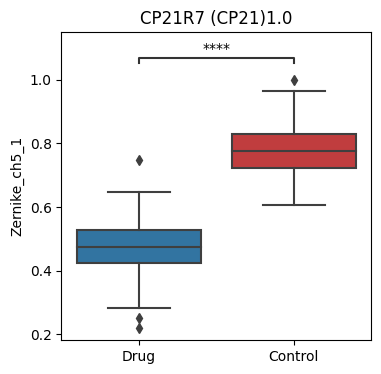

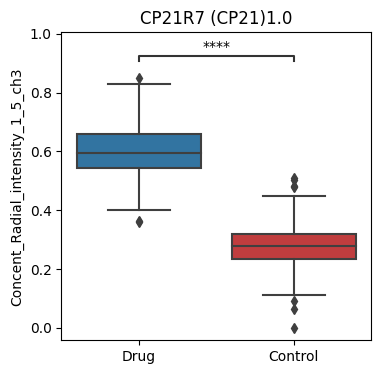

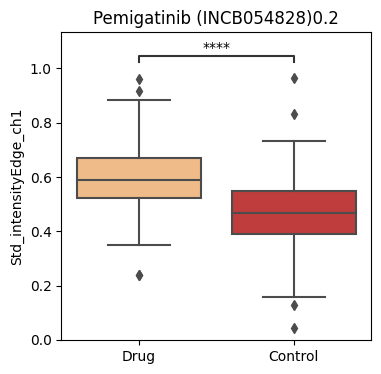

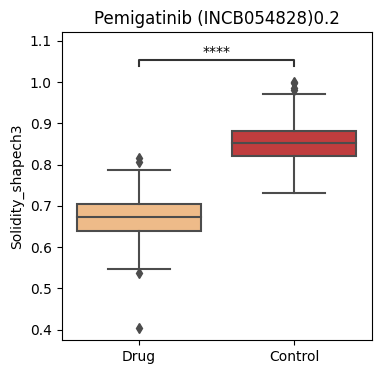

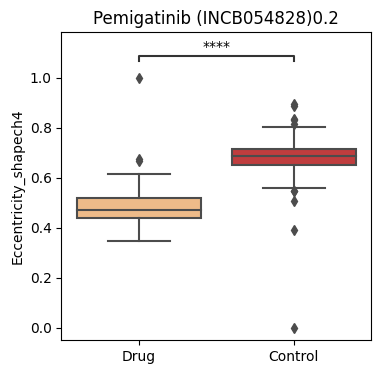

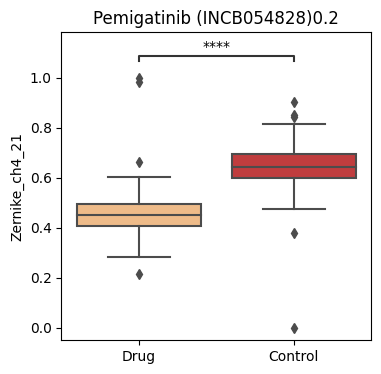

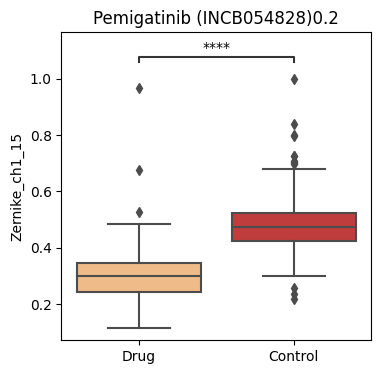

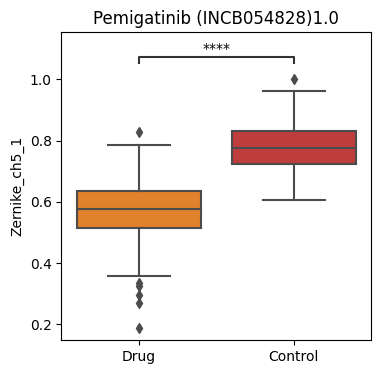

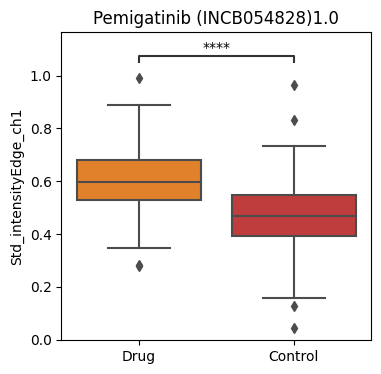

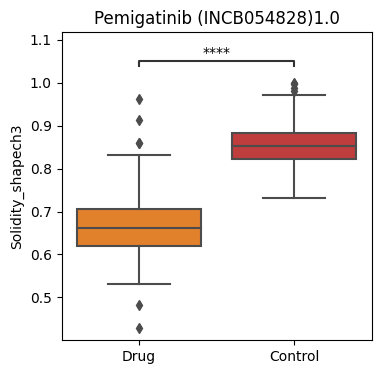

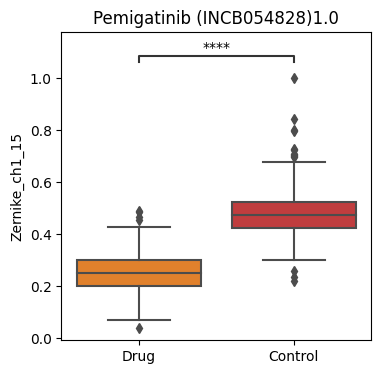

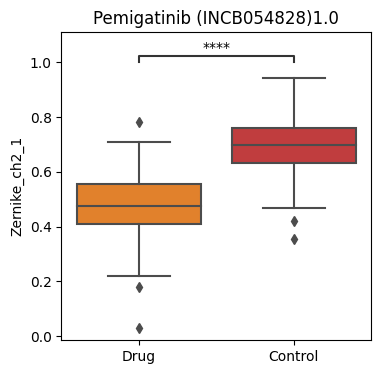

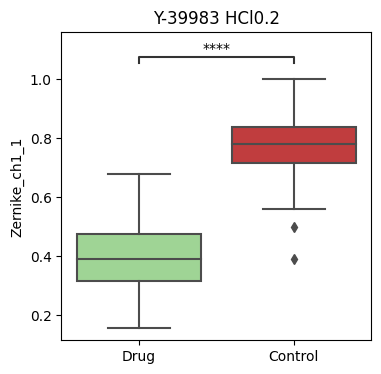

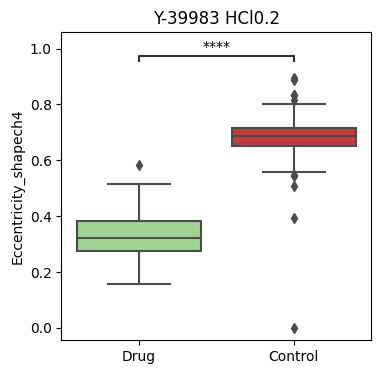

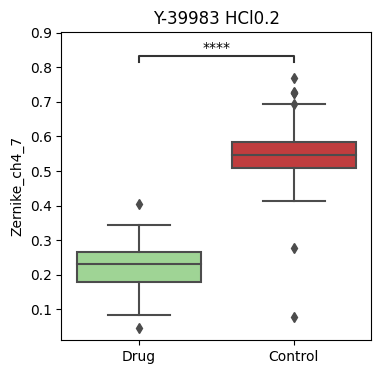

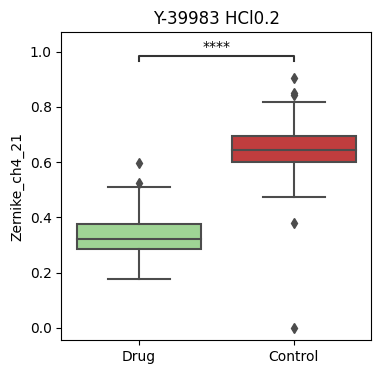

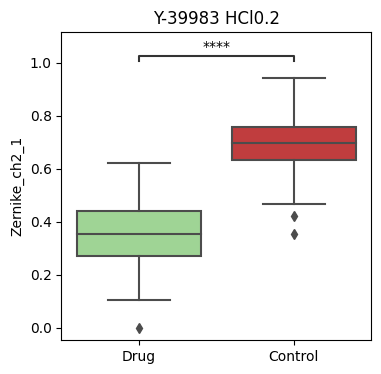

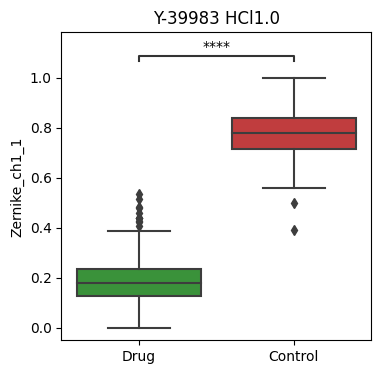

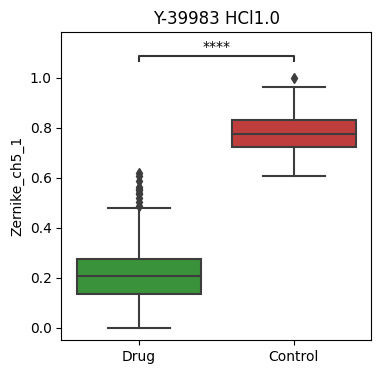

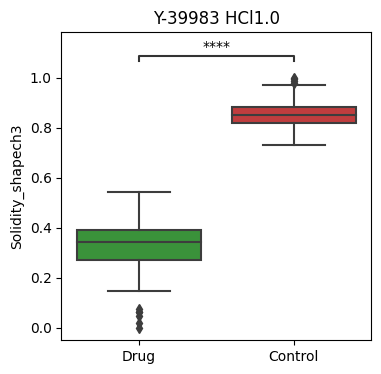

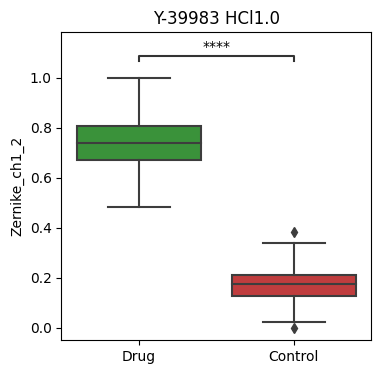

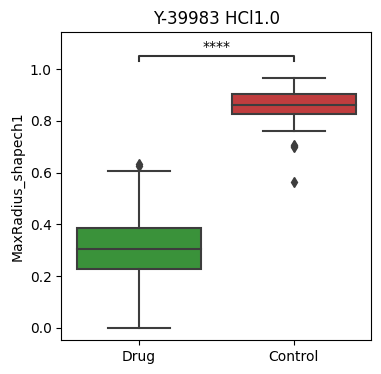

In [12]:
# Print the best 5 scoring features

pale=sns.color_palette("twilight",7).as_hex()
pale=['#aec7e8','#1f77b4', '#ffbb78', '#ff7f0e',  '#98df8a', '#2ca02c']
from statannot import add_stat_annotation

for r,i in enumerate(np.unique(Vecmean.loc[Vecmean.drug!='StockDMSO'].drug)):

    temp=Vecmean.loc[Vecmean.drug==i]
    temp=pd.concat([temp,Vecmean.loc[Vecmean.drug=='StockDMSO']],axis=0)
    temp2=tot_features_summary[i].loc[tot_features_summary[i].total_counts==5]
    temp2=temp2.sort_values(by='sum_of_coefficients',ascending=False)
    color=['#aec7e8','#1f77b4', '#ffbb78', '#ff7f0e',  '#98df8a', '#2ca02c'][r]

    for f in temp2.features[:5]:
        
        
        plt.subplots(figsize=(4,4))
        g=sns.boxplot(data=temp,y=f,x='drug',palette=[color,'#d62728'])
        add_stat_annotation(g, data=temp, x='drug',y=f, order=[i,'StockDMSO'],
                box_pairs=[(i,'StockDMSO')],
                test='Mann-Whitney', text_format='star',  verbose=0)
        plt.title(i)
        plt.xticks([0,1],['Drug','Control'])
        plt.xlabel('')
        plt.show()
         
           


In [13]:
# print the best features per drug and concentration
i='Pemigatinib (INCB054828)1.0'
best_features=tot_features_summary[i].loc[tot_features_summary[i].total_counts==5]
best_features=best_features.sort_values(by='sum_of_coefficients',ascending=False)
best_features

,features,coefficient_Plate1,coefficient_Plate2,coefficient_Plate3,coefficient_Plate4,coefficient_Plate5,sum_of_coefficients,total_counts
62,Zernike_ch5_1,-1.05154,-1.170522,-1.020566,-1.059104,-1.103203,5.404935,5
32,Std_intensityEdge_ch1,1.171753,1.075006,0.932205,0.86018,1.048023,5.087168,5
79,Solidity_shapech3,-0.982237,-1.05248,-0.952837,-0.974064,-0.940744,4.902362,5
43,Zernike_ch1_15,-0.95554,-0.902846,-0.950522,-0.991088,-1.018065,4.81806,5
129,Zernike_ch2_1,-0.868624,-0.962762,-0.945738,-0.91737,-1.066213,4.760706,5
...,...,...,...,...,...,...,...,...
97,Concent_Radial_intensity_3_4_ch3,0.312767,0.322527,0.253649,0.236917,0.250753,1.376614,5
83,TextCorrelation_dist_2angle2.09ch3,-0.302568,-0.2995,-0.258491,-0.215871,-0.279757,1.356186,5
95,Concent_Radial_intensity_1_7_ch3,0.273295,0.264775,0.232774,0.290644,0.288521,1.350009,5
151,Correlation_RWC2_ch4_ch3,-0.289126,-0.257246,-0.235548,-0.219608,-0.310887,1.312415,5
